In [ ]:
import xarray as xr
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert



In [17]:
%matplotlib notebook

In [2]:
ds = xr.open_dataset(r'C:/Users/mrayson/cloudstor/Data/IWAtlas\NWS_internal_tide_atlas.nc')
ds

<xarray.Dataset>
Dimensions:    (depth: 100, frq: 5, latitude: 1000, longitude: 1750, modes: 4, time: 12)
Coordinates:
  * time       (time) datetime64[ns] 2013-07-01 2013-08-01 ... 2014-06-01
  * frq        (frq) float64 0.0001405 0.0001454 0.0001379 7.292e-05 6.76e-05
  * modes      (modes) float64 0.0 1.0 2.0 3.0
  * latitude   (latitude) float64 -25.0 -24.98 -24.96 ... -5.06 -5.04 -5.02
  * longitude  (longitude) float64 107.5 107.5 107.5 107.6 ... 142.4 142.5 142.5
  * depth      (depth) float64 3.734 11.46 19.44 ... 5.792e+03 5.996e+03
Data variables:
    amp_b      (time, frq, modes, latitude, longitude) float64 ...
    phs_b      (time, frq, modes, latitude, longitude) float64 ...
    z          (latitude, longitude) float64 ...
    rho        (time, depth, latitude, longitude) float64 ...
Attributes:
    Name:          North West Shelf internal tide amplitude climatology
    Date created:  2018:11:05 21:59:57
    Author:        Matt Rayson
    Institution:   University of West

In [35]:
# Get the amplitude and phase for a given point
lonpt = 123.346383
latpt = -13.75895

lonpt = 122.8
latpt = -12.8

#lonpt = 123.3
#latpt = -14.2

mode = 0

t1 = '2013-07-01'
t2 = '2014-06-01'
dt = '30min'

In [36]:
my_amp = ds['amp_b'].sel(longitude=lonpt, latitude=latpt, modes=mode, method='nearest')
my_phs = ds['phs_b'].sel(longitude=lonpt, latitude=latpt, modes=mode, method='nearest')

# Convert to complex form
amp = my_amp*np.cos(my_phs) + 1j*my_amp*np.sin(my_phs)
amp

<xarray.DataArray (time: 12, frq: 5)>
array([[ 8.805226-12.925694j,  2.361568 -9.834484j, -2.093609 -1.628442j,
         3.740247 +0.7451j  , -0.874532 +2.785262j],
       [ 9.713085-14.087896j,  4.988814-10.204013j, -2.485796 -1.16557j ,
         3.000699 +0.455401j, -1.016502 +2.143712j],
       [10.801849-13.490623j,  3.056482-12.840312j, -2.713199 -1.354956j,
         2.912371 -0.175523j, -0.672437 +1.783734j],
       [14.466585 -8.458512j,  3.458295 -9.638971j, -2.336513 -2.181848j,
         2.816315 -1.013118j, -1.032634 +1.807211j],
       [11.175398 -8.905751j,  2.780973 -8.853683j, -0.35849  -0.826877j,
         3.795664 -1.061497j, -0.648175 +2.12316j ],
       [11.06795 -10.918114j,  2.489202 -7.991198j, -1.626118 -1.132321j,
         4.021598 -1.028143j, -0.705992 +1.833444j],
       [16.738679 -6.420156j,  6.96312  -5.96378j , -2.384137 -1.48089j ,
         4.355577 +0.606459j, -0.735822 +2.264746j],
       [14.98229  -6.156042j,  8.773072 -5.161514j, -1.002361 -3.641791j,

In [37]:
np.abs(amp.values[:,0])

array([15.63987144, 17.11177462, 17.28226941, 16.75793887, 14.28992378,
       15.54685593, 17.92768187, 16.19771132, 15.57978929, 15.83277114,
       16.39880094, 16.50566154])

In [38]:
# Interpolate the complex amplitude in time
# *note that the phases are since 1990-01-01
newtime = pd.date_range(start=t1, end=t2, freq = dt)

amp_new = amp.resample(time=dt).interpolate('linear').sel(time=newtime)

In [39]:
t1990 = (amp_new.time.values - np.datetime64('1990-01-01')).astype('timedelta64[s]').astype(float)
t1990

array([7.414848e+08, 7.414866e+08, 7.414884e+08, ..., 7.704252e+08,
       7.704270e+08, 7.704288e+08])

In [40]:
# Reconstruct the time series
amp_ts = np.zeros(t1990.shape[0], dtype=np.float)
for ii,ff in enumerate(amp.frq.values):
    amp_ts += np.real(amp_new.values[:,ii]*np.exp(-1j*ff*t1990))
    

In [41]:
# Calculate the envelope
amp_ts_h = hilbert(amp_ts)
env = np.abs(amp_ts_h)

<IPython.core.display.Javascript object>


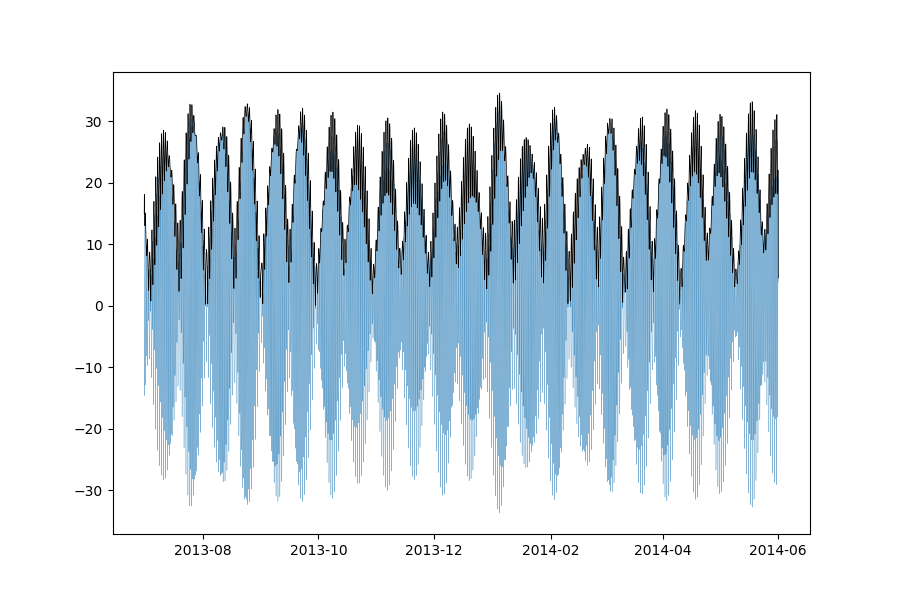

In [42]:
plt.figure(figsize=(9,6))
plt.plot(amp_new.time, amp_ts, lw=0.2)
plt.plot(amp_new.time, env, lw=0.5, c='k')

6.759774415077306e-05

In [48]:
t1990


array([7.414848e+08, 7.441632e+08, 7.468416e+08, 7.494336e+08,
       7.521120e+08, 7.547040e+08, 7.573824e+08, 7.600608e+08,
       7.624800e+08, 7.651584e+08, 7.677504e+08, 7.704288e+08])